In [1]:
%run init.ipynb


# We need to import additional libraries which implement clustering framework. 
# We used the scikit-learn python library: http://scikit-learn.org/stable/

import sklearn.cluster as skcl
import sklearn.metrics as skmetr

import matplotlib.patheffects as pe

# - PCA & K-Means Clustering

If other is not mentioned explicitly, we perform **PCA** for the ***1st*** and the ***2nd*** **principal components**.

- ### PCA framework.
A set of functions to be used for the *Principal Component Analysis*.

In [225]:
def pca(dataframe):
    # Given a dataframe scales (normalizes) it 
    # and computes the eigenvalues and eigenvectors 
    # of the corresponding covariance matrix.
    
    normDf = ((dataframe - dataframe.mean()) / \
              dataframe.std())

    covMatrix = normDf.cov()
    initEigvals, initEigvecs = np.linalg.eigh(covMatrix)

    sortedPairs = sorted(zip(initEigvals, initEigvecs.T), \
                    key = lambda item: -item[0])
    
    eigvals = [item[0] for item in sortedPairs]
    eigvecs = [item[1] for item in sortedPairs]
    
    return (normDf, eigvals, eigvecs)



def pcaProjection(normDf, eigvecs, pcN1 = 0, pcN2 = 1):
    # For two given principal components, calculates the positions
    # of data points in the factorial plane.
    
    xs = normDf @ eigvecs[pcN1]
    ys = normDf @ eigvecs[pcN2]
    
    return (xs, ys)



def pcaBiplot(points, variances, eigvecs, columns, \
              scaling=10.0, nArrows = -1, pcN1 = 0, pcN2 = 1, colors=None):
    # Produces the biplot w.r.t. two given principal components (zero-based);
    # The default value nArrows = -1 means arrows for ALL the variables. 
    
    xs = points[0]
    ys = points[1]
    
    pcN1VarExplained = variances[pcN1] / sum(variances) * 100
    pcN2VarExplained = variances[pcN2] / sum(variances) * 100
    
    varExplained = \
        pcN1VarExplained + pcN2VarExplained
    
    plt.figure(figsize=(15,12))
    plt.title("PCA: Factorial plane ({0:1.1f} % of variance explained)"\
              .format(varExplained), fontsize = 16, fontweight='bold')
    plt.xlabel("PC {0} ({1:1.1f} %)"\
               .format(pcN1 + 1, pcN1VarExplained), fontsize = 14, fontweight='bold')
    plt.ylabel("PC {0} ({1:1.1f} %)"\
               .format(pcN2 + 1, pcN2VarExplained), fontsize = 14, fontweight='bold')
    plt.scatter(xs, ys, c=colors, s = 30);
    
    arrows = []
    for x, y, col in zip(eigvecs[pcN1], eigvecs[pcN2], columns):
        arrows.append((x, y, col))
    arrows = sorted(arrows, key = \
                lambda item: -(item[0]**2 + item[1]**2))
    
    if nArrows == -1:
        nArrows = len(variances)
        
    for i in range(nArrows):
        arr = arrows[i]
        sclX, sclY = scaling*arr[0], scaling*arr[1]
        col = arr[2]
        ax = plt.gca()
        arr = plt.arrow(0,0, sclX, sclY, edgecolor='r', \
                        width=0.01, facecolor = 'r')
        annotX = sclX + 0.3*np.sign(sclX)
        annotY = sclY + 0.3*np.sign(sclY)
        txt = ax.annotate(col, xy=(sclX, sclY), xytext=(annotX, annotY), \
                   fontsize = 16, color='black')
        txt.set_path_effects([pe.withStroke(linewidth=2, foreground="w")])
        ax.add_patch(arr)
    
    plt.show()

    
    
def pcaScreeplot(variances, caption = "", pcN1 = 0, pcN2 = 1):
    # Given an ordered array of variances, plots the screeplot 
    # of a percentage of variance of scaled data 
    # explained by each principal component.

    totalVars = sum(variances)
    xs = [i+1 for i in range(len(variances))]
    ys = [v / totalVars * 100 for v in variances]

    plt.figure(figsize=(12,6))
    plt.title("PCA: Scree Plot {0}".format(caption), fontsize = 16, fontweight='bold')
    plt.xlabel("Principal Component", fontsize = 14, fontweight='bold')
    plt.ylabel("% of Variance Explained", fontsize = 14, fontweight='bold')
    plt.plot(xs, ys, 'bo-');
    

    
def pcaPerform(df, scaling=10, doBiplot = True):
    # Shortcut for PCA results for different datasets.
    
    normDf, variances, eigvecs = pca(df)
    xs, ys = pcaProjection(normDf, eigvecs)
    
    if doBiplot:
        pcaBiplot((xs, ys), \
              variances, eigvecs, df.columns, scaling=scaling)
    
    return (normDf, xs, ys, eigvecs, variances)

- ### K-Means Clustering Framework.
Below, we define some **functions** facilitating our *particular K-Means clustering tasks*. If not mentioned other, we use **K-Means++** approach for the initial centroids selection.

In [233]:
def performKMeans(normDf, nClusters):
    # Given a normalized dataset and a number of clusters,
    # performs the K-Means clustering and 
    # returns the clusters labels for each point and clusters centers. 
    
    kmeans = skcl.KMeans(n_clusters = nClusters, init = 'k-means++')
    kmeansModel = kmeans.fit(normDf)
    yKmeans = kmeans.predict(normDf)
    centers = kmeans.cluster_centers_
    
    silhScores = [skmetr.silhouette_score(\
                        normDf, kmeansModel.labels_,\
                        metric='euclidean', sample_size = 1000)\
                  for i in range(100)]
    
    return (yKmeans, centers, np.average(silhScores))



def plotClustersFP(points, centers, yKmeans):
    # Plots clustered points and clusters centers on the factorial plane.
    
    xs, ys   = points[0], points[1]
    cxs, cys = centers[0], centers[1]
    
    nClust = len(cxs)
    
    plt.figure(figsize = (15, 12))
    plt.title("N clusters: {0}".format(nClust), fontsize = 16, fontweight='bold')
    plt.xlabel('PC 1', fontsize = 14, fontweight='bold')
    plt.ylabel('PC 2', fontsize = 14, fontweight='bold')
    plt.scatter(xs, ys, c = yKmeans, s=20, cmap='viridis')
    plt.scatter(cxs, cys, c='black', s=150, alpha=0.5);
    
    
    
def findBestClustersN(normDf, lBound = 2, uBound = 20):
    # Find the best number of clusters in the K-Means sence 
    # according to the silhouette value criterion.
    
    silhScores = []

    for n in range(lBound, uBound):
        silh = performKMeans(normDf, n)[2]
        silhScores.append(silh)

    bestN = np.argmax(silhScores) + lBound
    print ("The best number of clusters is {0} with the silhouette score {1:1.2f}."\
           .format(bestN, silhScores[bestN - lBound]))
    
    return (bestN, silhScores)



def plotSilhScores(silhs):
    plt.figure(figsize=(12,6))
    plt.title("Silhouette Scores for different N clusters", fontsize = 16, fontweight='bold')
    plt.xticks(range(2, len(silhs) + 2))
    plt.xlabel("N Clusters", fontsize = 14, fontweight='bold')
    plt.ylabel("Silhouette Score", fontsize = 14, fontweight='bold')
    
    plt.plot(range(2, len(silhs)+2), silhs, 'bo-');
    

The function that does **both PCA Biplot and K-Means** clustering on *the same figure*.

In [218]:
def doPcaClustering(pca, nClust = 2, scaling=10):
    normDf = pca[0]
    xs, ys = pca[1], pca[2]
    eigvecs = pca[3]
    variances = pca[4]

    yKmeans, centers, silh = performKMeans(normDf, nClust)
    cxs, cys = pcaProjection(centers, eigvecs)
    pcaBiplot((xs,ys), variances, eigvecs, normDf.columns, \
              scaling, colors=yKmeans)

    print ("The silhouette score for N = {0} is {1:1.2f}".format(nClust, silh))

- ## Overall Analysis.

We take into account **all the numerical variables** EXCEPT the *ranking estimate for other positions*. It is exactly **representative** for the set of players on their **preferred positions**.

To perform clustering, we get the **necessary data** from the *PCA stage*.

After this, for the *general* **K-Means clustering** we need to *choose the parameter k* (the number of clusters).

To do this, we run the algorithm for **diferrent number of clusters** in a certain range, and then, based on the **silhouette score** for different number of clusters, we **pick the best one**. The **best number of clusters = 2** with the **silhouette score = 0.51**.

Finally, we plot the **clustered points on the factorial plane** to draw some *conclusions*.

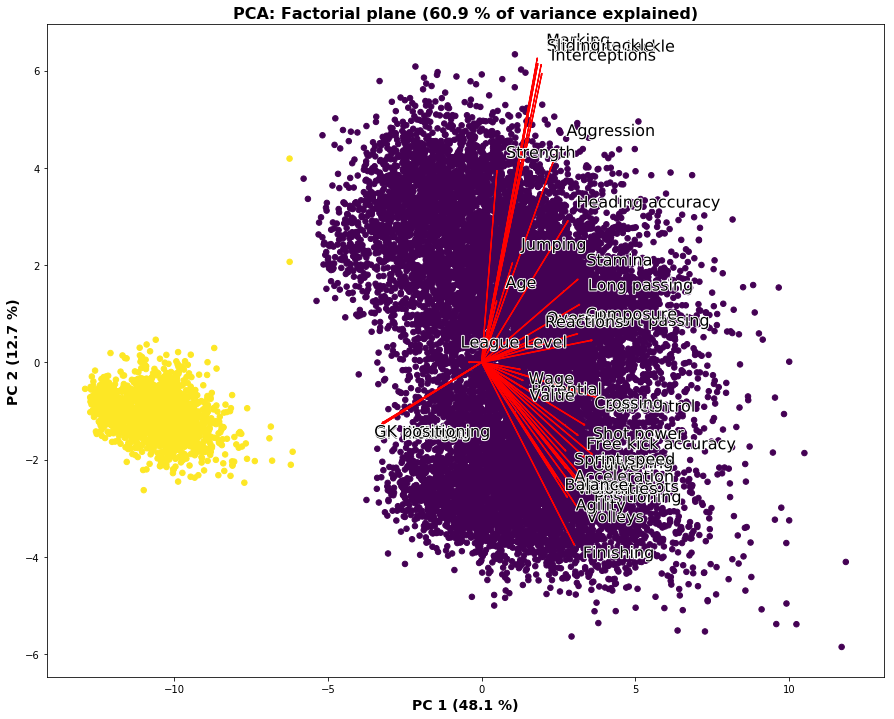

The silhouette score for N = 2 is 0.51


In [238]:
overallDf = df.select_dtypes(include='number')\
                .dropna(axis='columns')

overallPca = pcaPerform(overallDf, doBiplot = False)

## Commented out since it executes for a long time;
# nClust, ovSilhs = findBestClustersN(overallPca[0], 2, 20)

nClust = 2
doPcaClustering(overallPca, nClust, scaling=17)

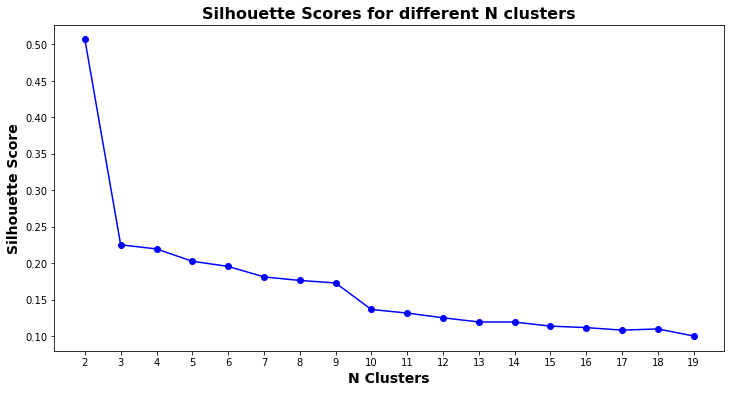

In [237]:
plotSilhScores(ovSilhs)

Since **two clusters** (*goalkeepers* and *outfielders*) is **quite a natural result** and **does not give any new information**, let us see what happens if we *increase* the number of clusters.

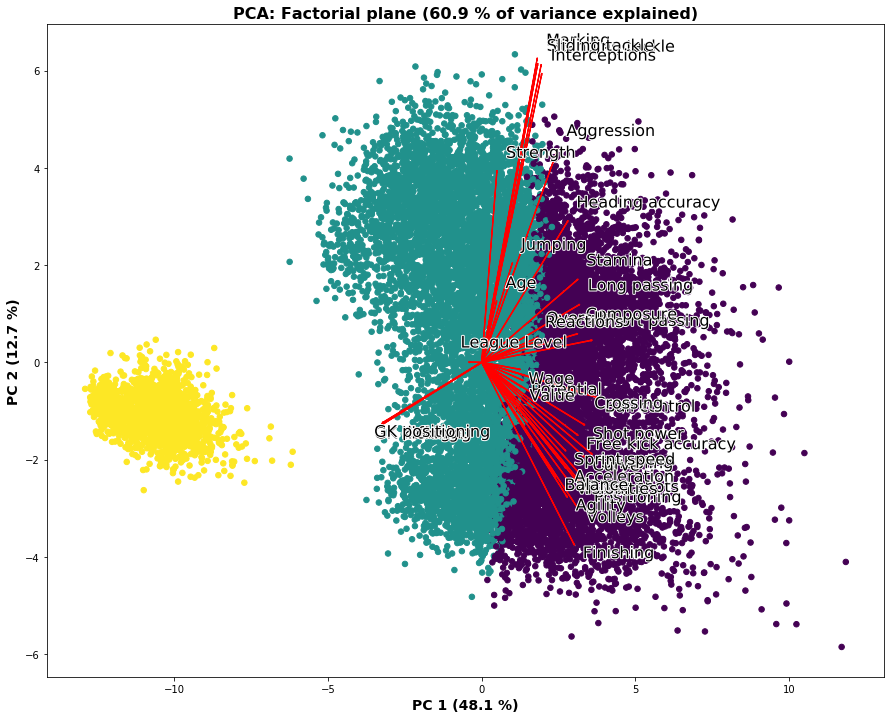

The silhouette score for N = 3 is 0.23


In [245]:
nClust = 3
doPcaClustering(overallPca, nClust, scaling=17)

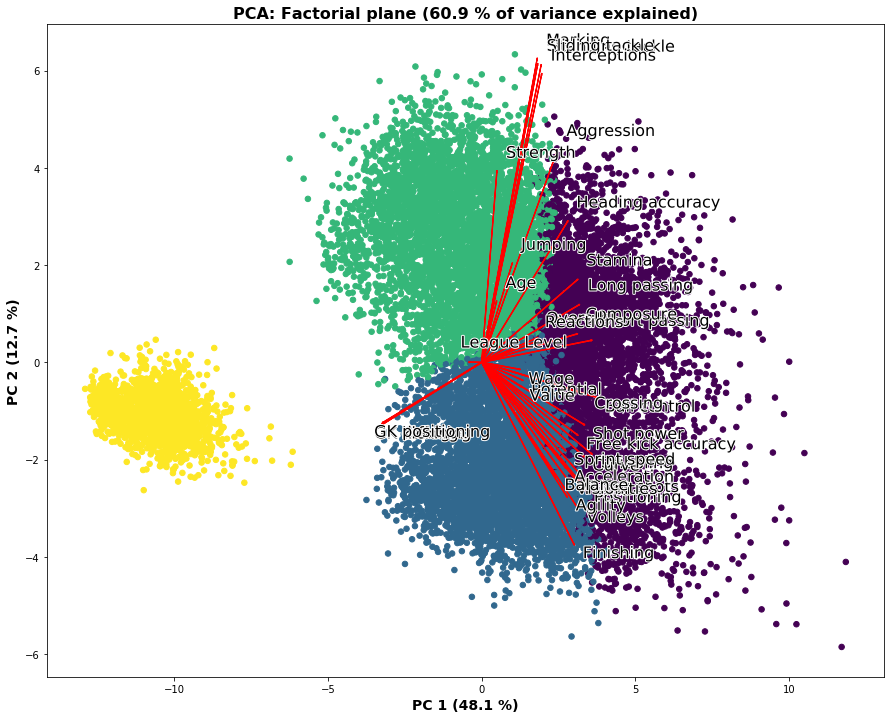

The silhouette score for N = 4 is 0.22


In [244]:
nClust = 4
doPcaClustering(overallPca, nClust, scaling=17)

### Conclusions:
#### PCA:
- The *factorial plane* represents **almost 2/3 of the total variance** in the dataset - quite a large percentage.
- The **1st PC** has to do with **goalkeeper vs outfielder variability**, and hence the dataset is naturally split into **two groups**: *goalkeepers* (the cluster on the left, since it posses the *maximal values of goalkeeping attributes*) and *outfielders* (on the right). That is why the 1st PC explain so much (almost 1/2) of all variance.
- The **2nd PC** is loaded mostly on such attributes as *marking, sliding tackle, interception, aggression etc.* (crucial for **defeding players**), and *finishing, volleys, acceleration, free kick accuracy, agility etc.* (crucial for **attacking players**), and they tend to be *negatively collinear*. **Hence**, the **2nd PC** has to do with the general position on a pitch (defender, midfielder or striker).
- **Consequence**: 2/3 of the variance is carried by *the role of players* (quite naturally). 
- **goalkeeping attributes** are *collinear* - very *higly correlated*.
- The *goalkeepers cluster* deserves a **closer look**.

#### Clustering:
The best number of clusters (in the range specified above) is 2 with the corresponding silhouette score 0.51. Hence,
- as was supposed in the PCA stage, the two **clusters represent the *goalkeepers*** (on the left) and **the *outfield players*** (on the right).
- the *silhouette score (0.51)* is quite high which means that **the clustering is adequate** (although quite obvious).
- taking ***the number of clusters = 3*** we observe that:
    - the silhouette score is now significantly smaller (0.23) -> clustering **is not very adequate**.
    - the **goalkeepers** cluster is **maintained**.
    - the **outfielders** are split into *'stronger'* and *'weaker'* players clusters (not depending on the position).
- taking ***the number of clusters = 4*** we observe that:
    - the silhouette score is now significantly smaller (0.23) -> clustering **is not very adequate**.
    - the **goalkeepers** cluster is **maintained**.
    - the **outfielders** are split into *'the strongest players'* (on the right), *'average attacking players'* and *'average defending players'* (on the left).
- we do not analyze *the other numbers of clusters* since **the silhouette is even smaller**.
- possibly, the **silhouette is close to 0** because in modern football *all the players are supposed to play both for defence and attack* (they share some common characteristics), and hence it is not easy to group them.
- to inquire more useful information about the dataset **we need** to run some **specific clustering tasks** (on the subsets of players and/or attributes). 

- ## Goalkeepers Analysis.

We consider all the **numerical variables** except the *ranking estimate for other positions* (by the assumptions of the dataset, for the goalkeepers it is set to NaN).

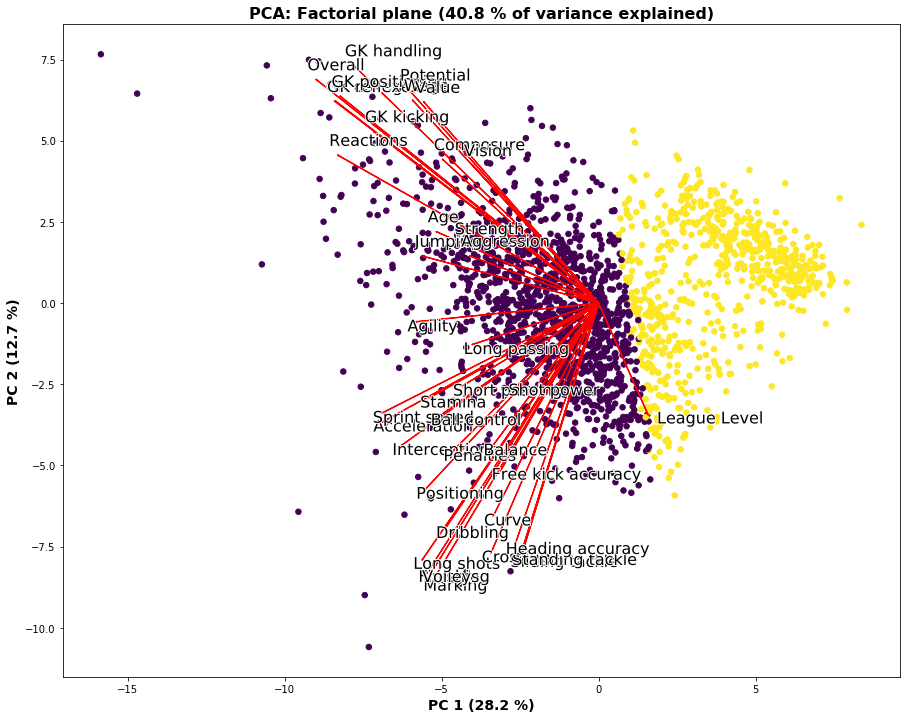

The silhouette score for N = 2 is 0.17


In [240]:
keepersDf = df[df["Preferred Positions"] == "GK"]\
                .select_dtypes(include='number')\
                .dropna(axis='columns')

keepersPca = pcaPerform(keepersDf, doBiplot = False)

## Commented out since it executes for a long time;
# nClust, gkSilhs = findBestClustersN(keepersPca[0], 2, 20)

nClust = 2
doPcaClustering(keepersPca, nClust, scaling=35)

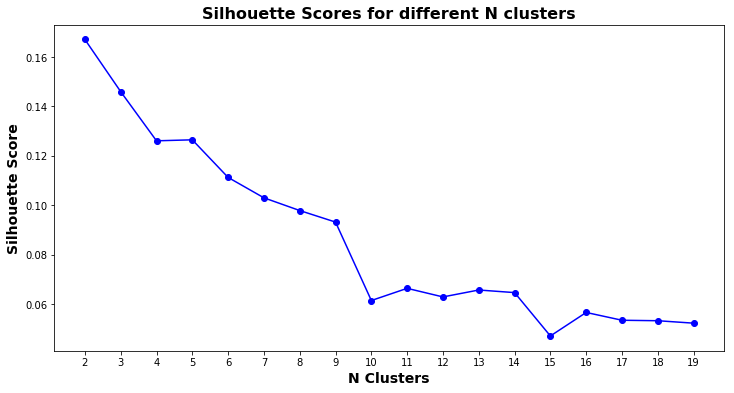

In [234]:
plotSilhScores(gkSilhs)

### Preliminary conclusions:
#### PCA:
- The *factorial plane* represents **nearly 1/2 of the total variance** in the dataset - quite large percentage.
- The **1st PC** has to do with the **general qualification of a player** (*the more* we move to the *left half-plane*, *the more skilled* is the player in general).
- The **2nd PC** is loaded mostly on *key goalkeeping attributes* (overall, GK handling, GK positioning etc.) with positive sign, and *outfield attributes* (dribbling, crossing etc.) with negative sign. Hence, the **2nd PC** has to do with **how good is a player on the goalkeeper position** (*the more* we move to the *upper half*, *the more goalkeeping skills* a player posseses). [**TODO**: formulate *clearlier*].
- the **key goalkeeping attributes** (overall, GK handling, GK positioning etc.) tend to be *collinear* (*highly correlated*).
- the **key goalkeeping attributes** are *negatively collinear* w.r.t. the **league level** (*the higher* the league *rank* (the smaller number), *the better goalkeepers* play there - quite naturally).

#### Clustering:
- Since the **best number of clusters = 2** with the **silhouette score = 0.17**, we conclude that for this dataset the general clustering is of **no practical use**; *the meaning* of the obtained clusters (although with a low silhouette score) could be *'good'* and *'bad'* players.

- ## Outfielders Analysis.

We consider all the **numerical variables**.

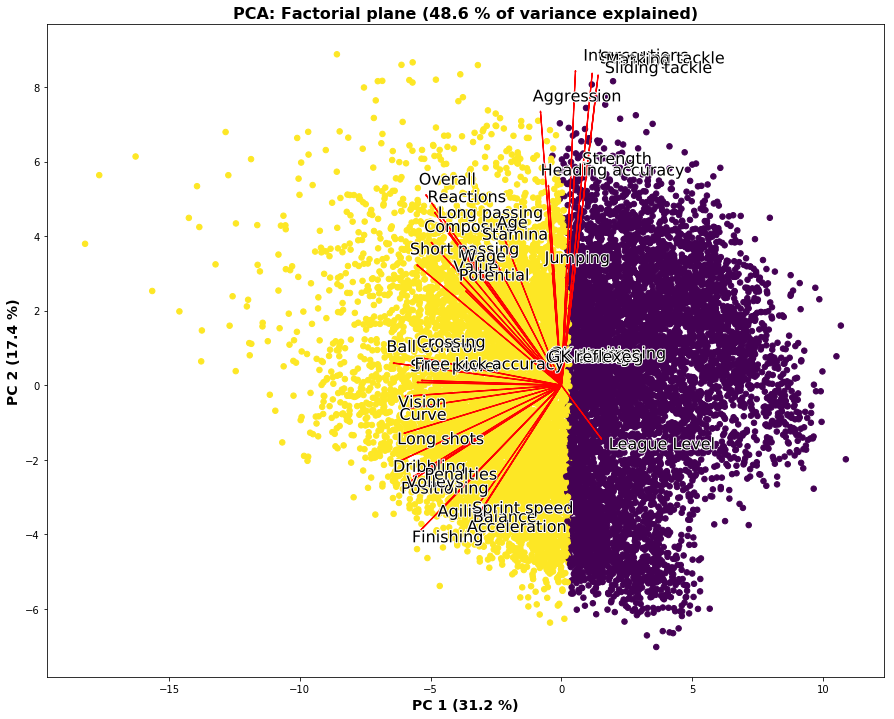

The silhouette score for N = 2 is 0.17


In [243]:
tempDf = df.dropna(axis='columns')
outfDf = tempDf[tempDf["Preferred Positions"] != "GK"]\
                    .select_dtypes(include='number')

outfPca = pcaPerform(outfDf, doBiplot = False)

## Commented out since it executes for a long time;
# nClust, outfSilhs = findBestClustersN(outfPca[0], 2, 20)

nClust = 2
doPcaClustering(outfPca, nClust, scaling=25)

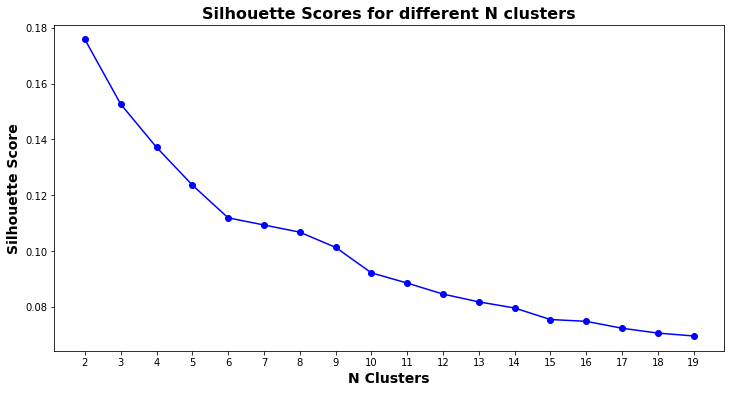

In [242]:
plotSilhScores(outfSilhs)

### Preliminary conclusions:
#### PCA:
- The *factorial plane* represents **almost 1/2 of the total variance** in the dataset - quite a large percentage.
- The **1st PC** has to do with *'good'* vs *'bad'*: the more to the left, the better characteristics player possesses.
- The **2nd PC** is loaded mostly on such attributes as *marking, sliding tackle, interception, aggression etc.* (crucial for **defeding players**), and *finishing, volleys, acceleration, free kick accuracy, agility etc.* (crucial for **attacking players**), and they tend to be *negatively collinear*. **Hence**, the **2nd PC** has to do with the general position on a pitch (defender, midfielder or striker).
- Crutial *attacking* and *defending attributes* respectively tend to be **collinear**.

#### Clustering:
- Since the **best number of clusters = 2** with the **silhouette score = 0.17**, we conclude that for this dataset the general clustering is of **no practical use**; *the meaning* of the obtained clusters (although with a low silhouette score) could be *'good'* and *'bad'* players.

- ## The Leagues Analysis.

**Question:** How is the ***variability*** among players ***dependent on the League Level***?

To answer it, let us **analyze the % of variance** explained by *first 2 PC* separately **for each league level**.

In [194]:
def getLeagueLevelDf(level):
    return df[df["League Level"] == level]\
                .select_dtypes(include='number')\
                .dropna(axis='columns')\
                .drop(["League Level"], axis=1)

In [182]:
league1Df = getLeagueLevelDf(1)
league1Pca = pcaPerform(league1Df, doBiplot=False)
                
league2Df = getLeagueLevelDf(2)
league2Pca = pcaPerform(league2Df, doBiplot=False)

league3Df = getLeagueLevelDf(3)
league3Pca = pcaPerform(league3Df, doBiplot=False)

league4Df = getLeagueLevelDf(4)
league4Pca = pcaPerform(league4Df, doBiplot=False)

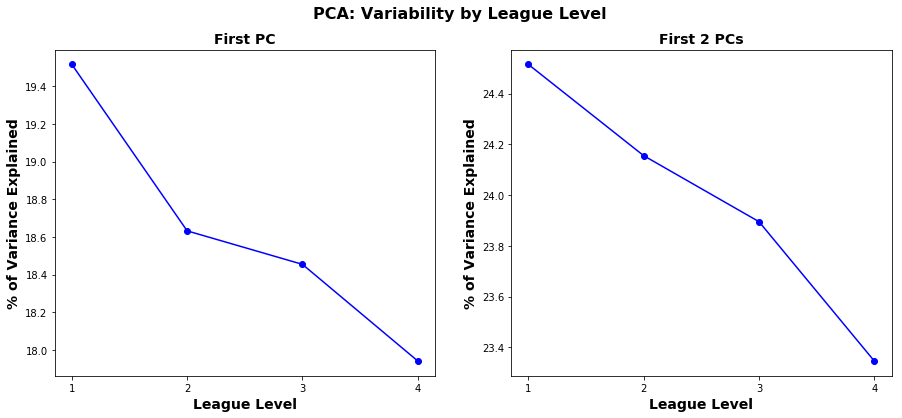

In [183]:
leagues = [1, 2, 3, 4]
varsExpl1 = [sum(league1Pca[4][:1]),\
             sum(league2Pca[4][:1]),\
             sum(league3Pca[4][:1]),\
             sum(league4Pca[4][:1])]

varsExpl2 = [sum(league1Pca[4][:2]),\
             sum(league2Pca[4][:2]),\
             sum(league3Pca[4][:2]),\
             sum(league4Pca[4][:2])]

f, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6));
f.suptitle("PCA: Variability by League Level", \
          fontsize = 16, fontweight='bold')

axs[0].set_title("First PC", fontsize = 14, fontweight='bold')
axs[0].set_xticks(leagues)
axs[0].set_xlabel("League Level", fontsize = 14, fontweight='bold')
axs[0].set_ylabel("% of Variance Explained",\
            fontsize = 14, fontweight='bold')
axs[0].plot(leagues, varsExpl1, 'bo-')

axs[1].set_title("First 2 PCs", fontsize = 14, fontweight='bold')
axs[1].set_xticks(leagues)
axs[1].set_xlabel("League Level", fontsize = 14, fontweight='bold')
axs[1].set_ylabel("% of Variance Explained",\
            fontsize = 14, fontweight='bold')
axs[1].plot(leagues, varsExpl2, 'bo-');

### Conclusion:
As can be seen from the picture above, the lower is the League Level, the less variability is carried by first 2 principal components. Hence, we can *conclude* that **the less is the league level, the more diverse are the players** *(in the sense of corresponding principal components explained above)*.

Let us know consider **PCA** and **cluster analysis** for all players *separately for each league level*.

- For the **League Level 1** we have

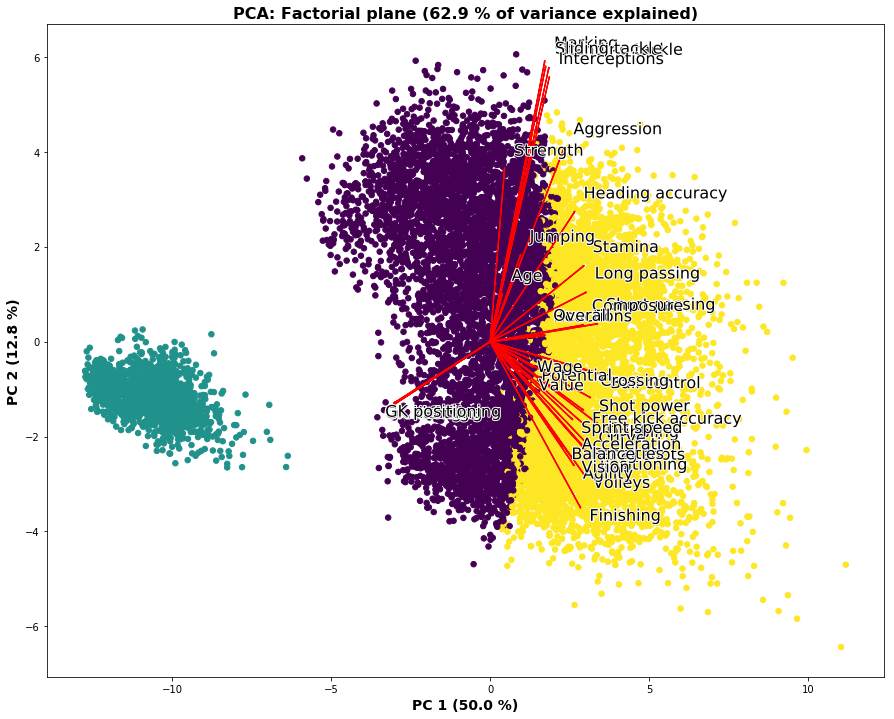

The silhouette score for N = 3 is 0.23


In [246]:
nClust = 3
doPcaClustering(league1Pca, nClust, scaling=16)

- For the **League Level 2** we have

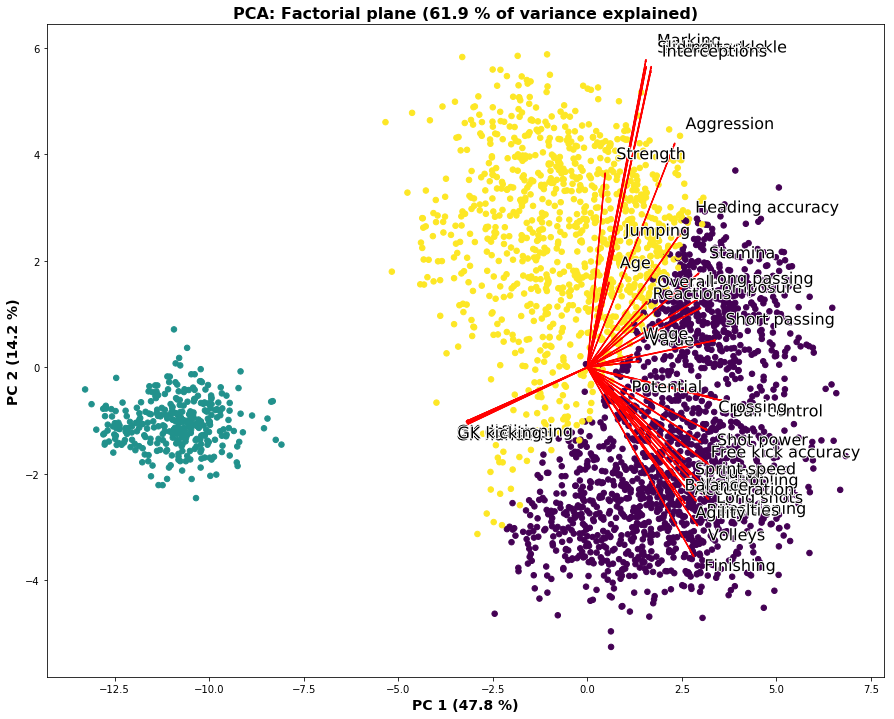

The silhouette score for N = 3 is 0.24


In [247]:
nClust = 3
doPcaClustering(league2Pca, nClust, scaling=16)

- For the **League Level 3** we have

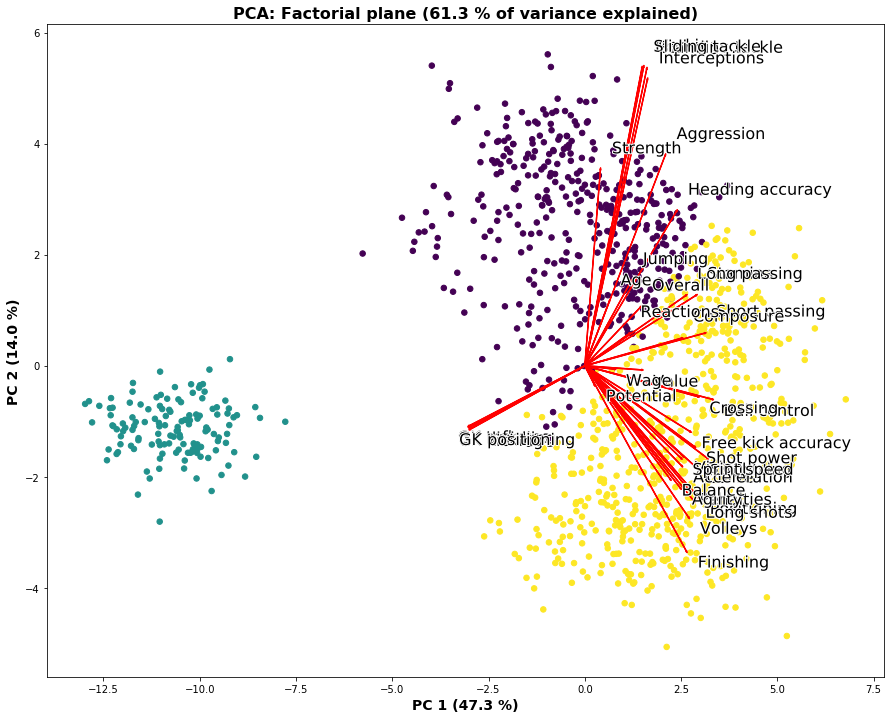

The silhouette score for N = 3 is 0.24


In [248]:
nClust = 3
doPcaClustering(league3Pca, nClust, scaling=15)

### Preliminary conclusions:
#### PCA:
- **The general structure** of the factorial plane **is maintained for all league levels** (roughly the same as in the overall case).
- The **difference** between league levels are that **the lower is the league level, the 'worse' are the players** (it can be seen from the lenghts of the arrows).


#### Clustering:
- **We do not consider here the case of 2 clusters** since it is the best with obvious meaning. 
- For the case of *top leagues*, **the conslusions from the overall analysis hold**.
- Cluster analysis for the league levels 2 and 3 now takes into account the positions of players -- the clusters are *'goalkeepers'*, *'defending players'* and *'attacking players'*.
- Cluster analysis **for the League Level 4 does not make sense** since there are *not enough data*.